In [88]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessamento import preprocessamento

def preprocessamento(caminho: str, proporcao_treino: float = 0.6, proporcao_teste: float = 0.2, proporcao_validacao: float = 0.2, autoencoder: bool = False):
    """
    Ao passar um dataFrame .csv, ele irá retornar geradores de dados para treino, teste e validação + os 3 .csv dividos igualmente os geradores.
    
    Parâmetros:
        caminho (str): Caminho para o arquivo CSV.
        proporcao_treino (float): Proporção de dados de treino.
        proporcao_teste (float): Proporção de dados de teste.
        proporcao_validacao (float): Proporção de dados de validação.
        autoencoder (bool): Se True, prepara os dados para um autoencoder (class_mode='input').
                            Se False, prepara os dados para classificação binária (class_mode='binary').
    
    Retorna:
        treino_gerador, validacao_gerador, teste_gerador, treino, teste, validacao
    """
    dataframe = pd.read_csv(caminho)

    treino, teste = train_test_split(dataframe, test_size=proporcao_teste, random_state=42)
    treino, validacao = train_test_split(treino, test_size=proporcao_validacao / (1 - proporcao_teste), random_state=42)

    img_width, img_height = 256, 256
    batch_size = 32

    preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
    treino_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    validacao_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    teste_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    class_mode = 'input' if autoencoder else 'binary'

    treino_gerador = treino_datagen.flow_from_dataframe(
        dataframe=treino,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe', #Usar a imagem como saída se for autoencoder
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode,  #Class mode baseado no parâmetro autoencoder
        shuffle=True
    )

    validacao_gerador = validacao_datagen.flow_from_dataframe(
        dataframe=validacao,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=True
    )

    teste_gerador = teste_datagen.flow_from_dataframe(
        dataframe=teste,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=False
    )

    return treino_gerador, validacao_gerador, teste_gerador, treino, teste, validacao

# Exemplo de uso
csv_file = 'Datasets_csv/df_PUC.csv'
train, teste, val, _, _, _ = preprocessamento(csv_file, 0.6, 0.2, 0.2, True)

Found 600 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.


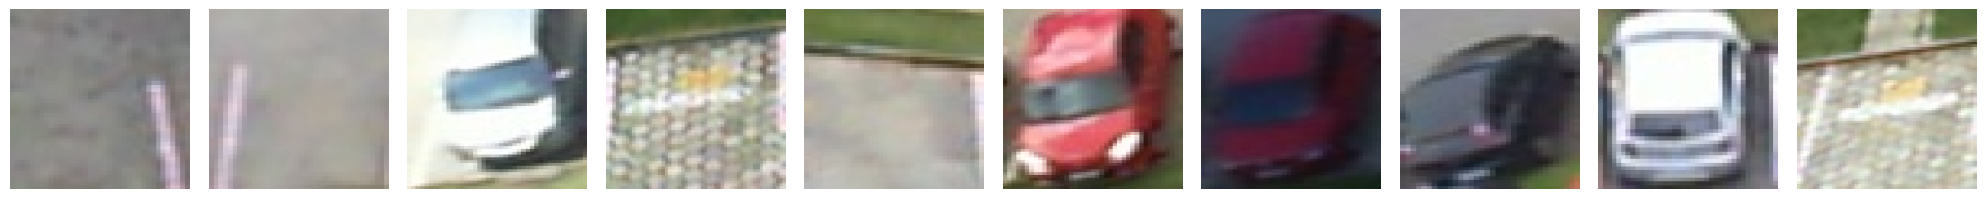

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Supondo que você tenha definido test_images e y corretamente após chamar next(train)
indice_imagem = 2
x_train, _ = next(train)
x_test, _ = next(teste)
x_val, _ = next(val)

n = 10  # Número de imagens a serem exibidas
plt.figure(figsize=(20, 4))
for i in range(n):
    # Mostrar a imagem original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].astype(np.uint8))  # Certifique-se de que suas imagens estão no formato correto
    plt.axis('off')
plt.tight_layout()
plt.show()


In [92]:
print("X_train", x_train.shape)
print("X_test", x_test.shape)

X_train (32, 256, 256, 3)
X_test (32, 256, 256, 3)


In [157]:
import matplotlib.pyplot as plt

def show_data(data, height=256, width=256, title=None, is_encoded=False):
    n = 10  # Número de imagens a serem exibidas
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        if is_encoded:
            img = data[i].reshape((height // 16, width // 16))  # Redimensiona para imagem codificada
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(data[i].reshape((height, width)), cmap='gray')  # Redimensiona para imagem original ou decodificada
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [127]:
def pre_process(X):
    X = X.reshape((len(X), 256*256*3))
    return X

X_train  =  pre_process(x_train)
X_test  =  pre_process(x_test)

print("X_train", X_train.shape)
print("X_test", X_test.shape)

X_train (32, 196608)
X_test (32, 196608)


ValueError: cannot reshape array of size 196608 into shape (256,256)

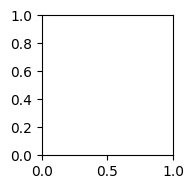

In [159]:
# Exibindo exemplos de imagens de treino
show_data(X_train, title="Exemplos de imagens de treino")
show_data(X_test, title="Exemplos de imagens de Teste")


In [118]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Definindo as dimensões
input_dim = 196608
output_dim = 196608
flattened_input_dim = 256 * 256 * 3
encode_dim = 100
hidden_dim = 256


In [130]:
input_layer = Input(shape=(input_dim,), name="INPUT")
hidden_layer_1 = Dense(hidden_dim, activation='relu', name="HIDDEN_1")(input_layer)

# code
code_layer = Dense(encode_dim, activation='relu', name="CODE")(hidden_layer_1)

# decoder
hidden_layer_2 = Dense(hidden_dim, activation='relu', name="HIDDEN_2")(code_layer)
output_layer = Dense(output_dim, activation='sigmoid', name="OUTPUT")(hidden_layer_2)

# Construindo o modelo
autoencoder = Model(input_layer, output_layer)

# Compilando o modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Sumário do modelo
autoencoder.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ INPUT (InputLayer)              │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HIDDEN_1 (Dense)                │ (None, 256)            │    50,331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CODE (Dense)                    │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HIDDEN_2 (Dense)                │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUTPUT (Dense)                  │ (None, 196608)         │    50,528,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,911,716 (384.95 MB)

 Trainable params: 100,911,716 (384.95 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
autoencoder.fit(X_train, X_train, epochs=5)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 2.4011
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: -176904.7344
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: -689590.7500
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: -1682047.2500
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: -3316809.0000


In [134]:
decoded_data = autoencoder.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


In [135]:
get_encoded_data = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("CODE").output)


In [136]:
encoded_data = get_encoded_data.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [138]:
print("Valor mínimo no decoded_data:", decoded_data.min())
print("Valor máximo no decoded_data:", decoded_data.max())


Valor mínimo no decoded_data: 1.0
Valor máximo no decoded_data: 1.0


In [172]:
def show_data(X, n=10, height=256, width=256, title="", is_encoded=True):
    plt.figure(figsize=(15, 3))  # Ajustando o tamanho da figura conforme necessário
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        if is_encoded == False:
            plt.imshow((X[i]/255.0).reshape((height, width, 3)))  # Reshape para (256, 256, 3) para imagens RGB
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            num_channels = 3
            n_samples = X_raw.shape[0]
            X = X_raw.reshape((n_samples, height, width, num_channels))
    plt.suptitle(title, fontsize=20)
    plt.show()

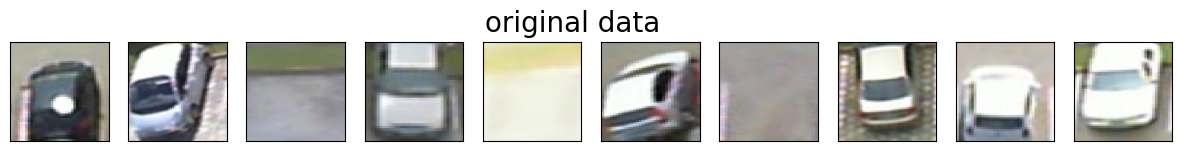

ValueError: cannot reshape array of size 100 into shape (256,256,3)

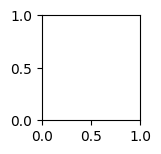

In [171]:
show_data(X_test, title="original data")
show_data(encoded_data, height=256, width=256, title="encoded data", is_encoded=True)
show_data(decoded_data, title="decoded data")